In [ ]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rarfile


In [ ]:
import rarfile

# Ruta al archivo RAR que deseas descomprimir
archivo_rar = '/content/drive/MyDrive/ia pro 2/laboratorio6/DatasetPerros_B_S.rar'

# Carpeta donde deseas extraer los archivos
carpeta_destino = '/content/rar_extraido'

# Abrir el archivo RAR
with rarfile.RarFile(archivo_rar) as rf:
    # Extraer todo el contenido del archivo RAR en la carpeta destino
    rf.extractall(carpeta_destino)

    print("¡Descompresión completada!")

¡Descompresión completada!


In [ ]:
import xml.etree.ElementTree as ET

def cargar_dataset_train(ruta_dataset, ruta_annotations, tamaño_imagen=(50, 50)):
    dataset = []

    # Recorrer las clases en el dataset
    for clase in os.listdir(ruta_dataset):
        ruta_clase = os.path.join(ruta_dataset, clase)
        ruta_clase_annotations = os.path.join(ruta_annotations, clase)

        if os.path.isdir(ruta_clase):
            with os.scandir(ruta_clase) as entries:
                for entry in entries:
                    if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                        imagen_ruta = os.path.join(ruta_clase, entry.name)
                        imagen = Image.open(imagen_ruta).convert('RGB')

                        # Preparar la ruta a la anotación correspondiente
                        nombre_base = os.path.splitext(entry.name)[0]
                        archivo_annotation = nombre_base + '.xml'
                        annotation_ruta = os.path.join(ruta_clase_annotations, archivo_annotation)

                        try:
                            etiqueta = parse_xml_annotation(annotation_ruta)
                            # Verificar si la anotación contiene objetos
                            if len(etiqueta['annotation']['object']) > 0:
                                # Verificar si el bounding box es None
                                if all(obj['bndbox'] is not None for obj in etiqueta['annotation']['object']):
                                    # Procesamiento de la imagen
                                    imagen = np.array(imagen) / 255.0
                                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                                    dataset.append((imagen_resized, etiqueta))
                        except FileNotFoundError:
                            print(f"No se encontró la anotación para {entry.name}")
                            continue

    random.shuffle(dataset)
    return dataset

def parse_xml_annotation(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotation = {
        'annotation': {
            'folder': root.find('folder').text,
            'filename': root.find('filename').text,
            'source': {
                'database': root.find('source/database').text,
                'annotation': root.find('source/annotation').text,
                'image': root.find('source/image').text
            },
            'size': {
                'width': root.find('size/width').text,
                'height': root.find('size/height').text,
                'depth': '3'
            },
            'segmented': root.find('segmented').text,
            'object': [{
                'name': obj.find('name').text,
                'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                'truncated': obj.find('truncated').text,
                'occluded': obj.find('occluded').text,
                'bndbox': {'xmin': obj.find('bndbox/xmin').text, 'ymin': obj.find('bndbox/ymin').text, 'xmax': obj.find('bndbox/xmax').text, 'ymax': obj.find('bndbox/ymax').text},
                'difficult': obj.find('difficult').text
            } for obj in root.findall('object')]
        }
    }
    return annotation

# Ejemplo de uso
ruta_annotations = '/content/rar_extraido/DatasetPerros_B_S/Anotaciones'
ruta_imagenes = '/content/rar_extraido/DatasetPerros_B_S/Perros_dataset'
dataset = cargar_dataset_train(ruta_imagenes, ruta_annotations)

In [ ]:
len(dataset)

8000

In [ ]:
classes = ['Afgano', 'Beagle', 'Collie', 'Cooker', 'German_Pointer', 'Golden_retriever', 'Pug', 'Schnauzer']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = dataset[ix]
  # print("+++"*10)
  # print(img)
  # print("..."*10)
  # print(label)
  # print("+++"*10)
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(float(bb['xmin'])), int(float(bb['ymin'])), int(float(bb['xmax'])) - int(float(bb['xmin'])), int(float(bb['ymax'])) - int(float(bb['ymin']))] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns


def plot_anns(img, anns, ax=None, bg=-1, classes=classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      bb = torch.tensor(bb)
      x, y, w, h = bb.detach().numpy()
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

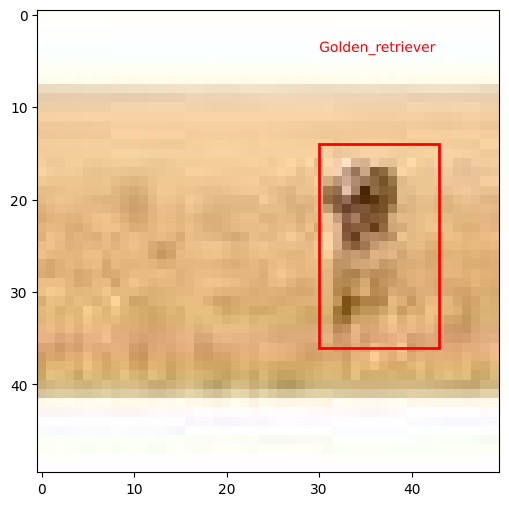

In [ ]:
img_np, anns = get_sample(5)
plot_anns(img_np, anns)
plt.show()

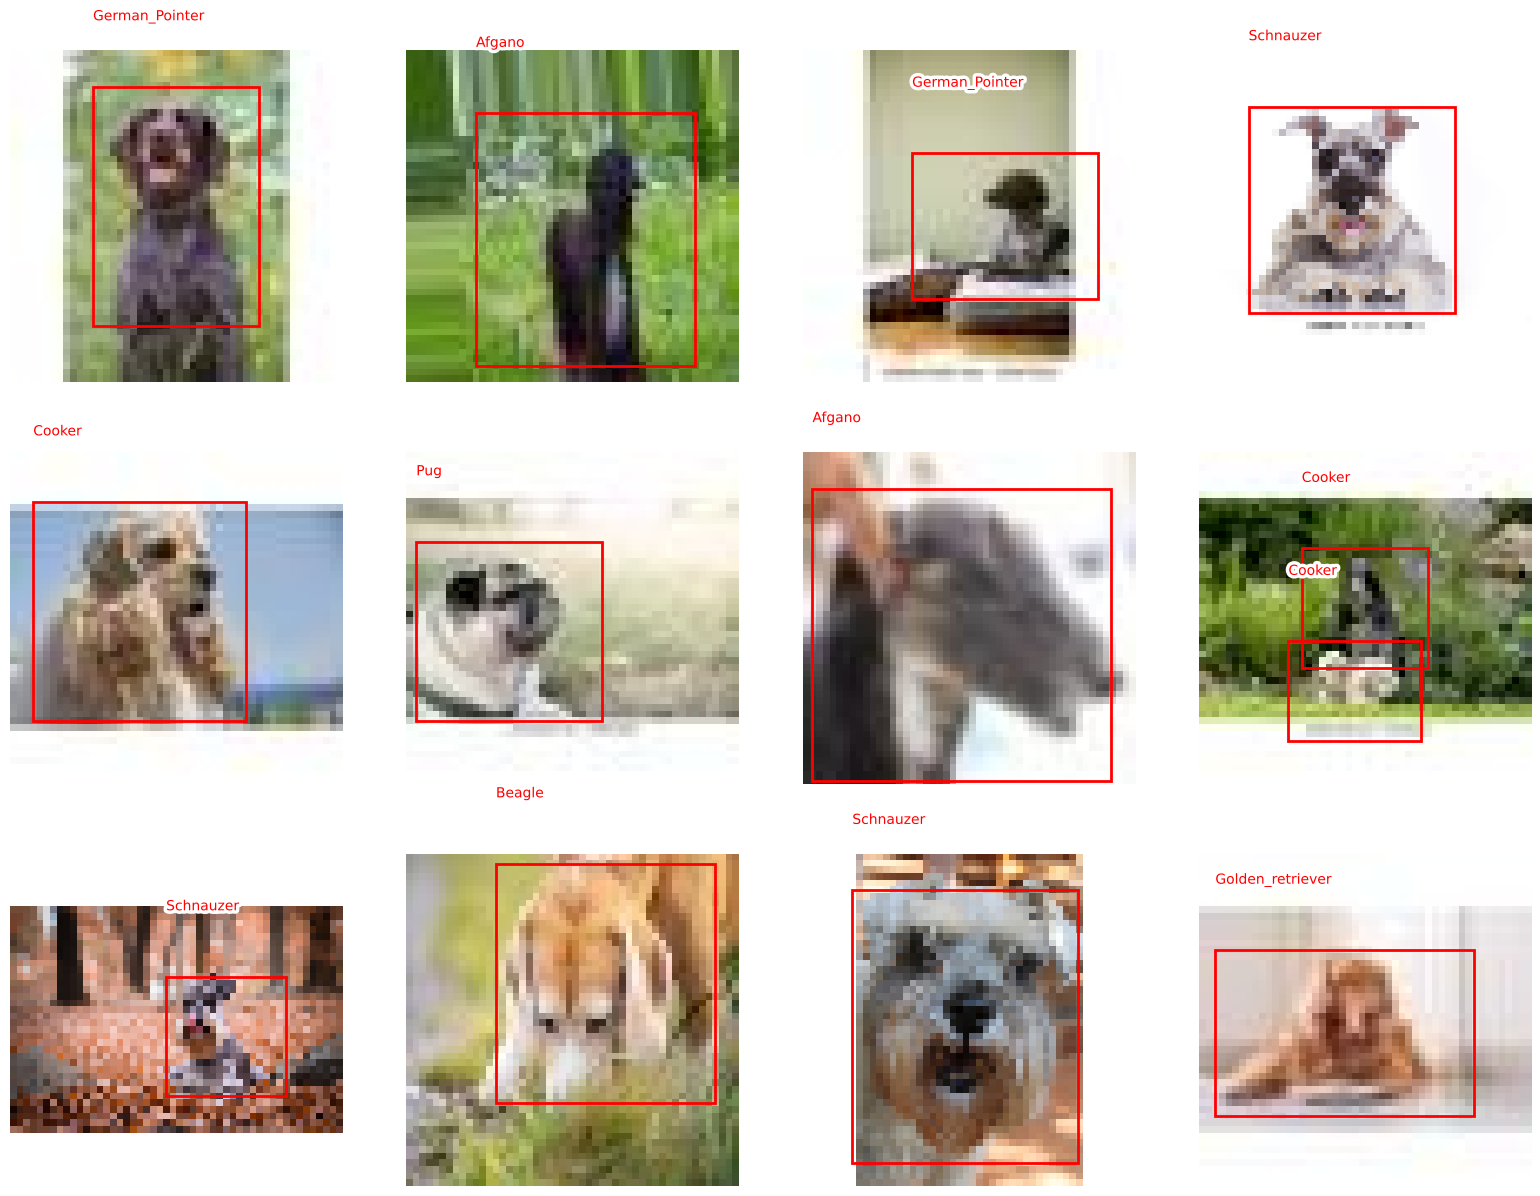

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
dataset[6999]

(<PIL.Image.Image image mode=RGB size=50x50>,
 {'annotation': {'folder': 'golden',
   'filename': 'golden_retriever_456.jpg',
   'source': {'database': 'Unknown',
    'annotation': 'Unknown',
    'image': 'Unknown'},
   'size': {'width': '50', 'height': '50', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'Golden_retriever',
     'pose': None,
     'truncated': '0',
     'occluded': '0',
     'bndbox': {'xmin': '13.45',
      'ymin': '10.8',
      'xmax': '40.35',
      'ymax': '37.6'},
     'difficult': '0'}]}})

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Ejemplo de uso
transform = transforms.Compose([
    transforms.Resize((50, 50)),
])

class VOCDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        super().__init__()

        self.dataset = dataset
        self.transforms = transforms

    def __getitem__(self, index):
        image, annotation = self.dataset[index]

        # Convertir la imagen a formato numpy
        image = np.array(image)

        # Extraer las cajas delimitadoras y las etiquetas
        boxes = []
        labels = []
        for obj in annotation['annotation']['object']:
            bbox = obj['bndbox']
            # Se encontraron coordenadas de caja delimitadora, convertirlas a punto flotante
            x1, y1, x2, y2 = int(float(bbox['xmin'])), int(float(bbox['ymin'])), int(float(bbox['xmax'])), int(float(bbox['ymax']))
            # Validar y rellenar si alguna coordenada es 0
            if x1 == 0:
                x1 = 1.0
            if y1 == 0:
                y1 = 1.0
            if x2 == 0:
                x2 = 1.0
            if y2 == 0:
                y2 = 1.0
            # Agregar las coordenadas y la etiqueta a las listas correspondientes
            boxes.append([x1, y1, x2, y2])
            labels.append(obj['name'])

        # Convertir la imagen y las cajas a tensores
        image = torch.tensor(image/255., dtype=torch.float32).permute(2, 0, 1)  # Convertir a tensor y permutar dimensiones
        boxes = torch.tensor(boxes, dtype=torch.float32)
        label_map = {'Afgano':0, 'Beagle':1, 'Collie':2, 'Cooker':3, 'German_Pointer':4, 'Golden_retriever':5, 'Pug':6, 'Schnauzer':7}
        #label_map = {'German_Pointer': 0}
        labels = [label_map[label] for label in labels]
        labels = torch.tensor(labels, dtype=torch.int64)

        anns = {}
        anns['boxes'] = boxes
        anns['labels'] = labels

        return image, anns

    def __len__(self):
        return len(self.dataset)

voc_dataset = VOCDataset(dataset, transforms=transform)

In [ ]:
voc_dataset[8]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          ...,
          [0.9882, 0.9882, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [0.9882, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.9843, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9843, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models import mobilenet_v2

def create_faster_rcnn_mobilenet(num_classes):
    # Cargar el modelo MobileNet pre-entrenado
    backbone = mobilenet_v2(pretrained=False).features

    # Modificar el clasificador para ajustarse al número de clases de tu problema
    backbone.out_channels = 8  # El número de canales de salida de MobileNet

    # Crear el modelo Faster R-CNN con MobileNet como backbone
    model = FasterRCNN(backbone, num_classes)

    return model

# Número de clases en tu conjunto de datos
num_classes = 10  # Por ejemplo, si tienes 10 clases de objetos diferentes

# Crear el modelo Faster R-CNN con MobileNet
model = create_faster_rcnn_mobilenet(num_classes)


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidu

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
classes_perro = ['Afgano', 'Beagle', 'Collie', 'Cooker', 'German_Pointer', 'Golden_retriever', 'Pug', 'Schnauzer']

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes_perro))

In [ ]:
model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
train_loader = DataLoader(voc_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
for idx, (image, target) in enumerate(train_loader):
    if target[0]['boxes'].shape[0] == 0:
        # Verificar si hay elementos en el tensor de etiquetas
        if len(target[0]['labels']) > 0:
            # Obtener el nombre de la clase más probable
            class_idx = torch.argmax(target[0]['labels'])
            class_name = classes_perro[class_idx]
            print(f"La imagen en el índice {idx} no tiene cajas delimitadoras. Clase más probable: {class_name}")
        else:
            print(f"La imagen en el índice {idx} no tiene cajas delimitadoras y no se encontraron etiquetas.")
        # Mostrar o guardar la imagen correspondiente
        plt.imshow(image[0].permute(1, 2, 0))
        plt.show()

In [ ]:
voc_dataset[6]

(tensor([[[0.2078, 0.2196, 0.2902,  ..., 0.3020, 0.3137, 0.2941],
          [0.2196, 0.2196, 0.2118,  ..., 0.3765, 0.3098, 0.2863],
          [0.2275, 0.2431, 0.2196,  ..., 0.3922, 0.3176, 0.2980],
          ...,
          [0.2353, 0.2549, 0.2549,  ..., 0.2941, 0.2863, 0.1961],
          [0.2000, 0.2314, 0.2431,  ..., 0.2510, 0.2980, 0.1922],
          [0.2039, 0.2471, 0.2392,  ..., 0.2588, 0.3137, 0.2039]],
 
         [[0.2000, 0.2196, 0.2902,  ..., 0.2235, 0.2471, 0.2275],
          [0.2039, 0.2157, 0.2078,  ..., 0.3020, 0.2353, 0.2235],
          [0.2000, 0.2196, 0.1961,  ..., 0.3098, 0.2353, 0.2235],
          ...,
          [0.1686, 0.1882, 0.1804,  ..., 0.1961, 0.2157, 0.1294],
          [0.1373, 0.1647, 0.1608,  ..., 0.1451, 0.2157, 0.1176],
          [0.1490, 0.1843, 0.1529,  ..., 0.1529, 0.2235, 0.1294]],
 
         [[0.1020, 0.1176, 0.1804,  ..., 0.1176, 0.1294, 0.1098],
          [0.1059, 0.1059, 0.0980,  ..., 0.1843, 0.1176, 0.0941],
          [0.0980, 0.1176, 0.0941,  ...,

In [ ]:
images, targets = next(iter(train_loader))

# Convierte la lista de imágenes y los tensores de objetivos en el formato esperado por el modelo
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]

# Pasa las imágenes y los objetivos al modelo
output = model(images, targets)

In [ ]:
output

{'loss_classifier': tensor(2.0872, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0249, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6958, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0249, grad_fn=<DivBackward0>)}

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

In [ ]:
from tqdm import tqdm
import math

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}+1, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

    torch.save(model.state_dict(), f'pesos_epoch_{epoch}.pth')
    print("Pesos del modelo guardados después del entrenamiento del epoch", epoch)

In [ ]:
num_epochs=5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

  0%|          | 0/1000 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a99845360>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a99845360><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a99845360><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a99845360>

Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
            self._shutdown_workers()

  File

Epoch 0+1, lr: 0.001000, loss: 0.178398, loss_classifier: 0.085107, loss_box: 0.074958, loss_rpn_box: 0.006067, loss_object: 0.012265
Pesos del modelo guardados después del entrenamiento del epoch 0


100%|██████████| 1000/1000 [26:05<00:00,  1.57s/it]


Epoch 1+1, lr: 0.001000, loss: 0.148383, loss_classifier: 0.069759, loss_box: 0.064457, loss_rpn_box: 0.005408, loss_object: 0.008759
Pesos del modelo guardados después del entrenamiento del epoch 1


100%|██████████| 1000/1000 [25:59<00:00,  1.56s/it]


Epoch 2+1, lr: 0.001000, loss: 0.134477, loss_classifier: 0.061402, loss_box: 0.060086, loss_rpn_box: 0.005053, loss_object: 0.007934
Pesos del modelo guardados después del entrenamiento del epoch 2


 39%|███▊      | 387/1000 [10:04<16:04,  1.57s/it]

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Inicializa el modelo con pesos predeterminados
model = fasterrcnn_resnet50_fpn(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes_perro))

In [ ]:
# Especifica la ruta del archivo que contiene tus pesos pre-entrenados
weights_path = "C:\ia2\laboratorio6pro\pesos_epoch_4.pth"

# Carga los pesos en el modelo
model.load_state_dict(torch.load(weights_path))

# Coloca el modelo en modo de evaluación
model.eval()

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23696\971355145.py:2: SyntaxWarning: invalid escape sequence '\i'
  weights_path = "C:\ia2\laboratorio6pro\pesos_epoch_3.pth"


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Especifica la ruta del archivo que contiene tus pesos pre-entrenados
weights_path = "C:\ia2\laboratorio6pro\laboratorio6\pesos_epoch_4.pth"

# Carga los pesos en el modelo
model.load_state_dict(torch.load(weights_path))

# Coloca el modelo en modo de evaluación
model.eval()

In [ ]:
from torchvision.io.image import read_image
img_carga = "Perrosprueba.jpeg"
img = read_image(img_carga)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Convertir el tensor de imagen a una imagen PIL
img_pil = transforms.ToPILImage()(img)

# Redimensionar la imagen a 50x50
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Aplicar la transformación a la imagen PIL
img_resized = transform(img_pil)

# Convertir la imagen a un tensor
img_tensor = img_resized.float()

# Escalar los valores de píxeles al rango [0, 1]
img_tensor /= 255.

# Asegurar que la forma del tensor sea (C, H, W)
img_tensor = [img_tensor.permute(0,2,1)]

# Mostrar la forma final del tensor
#img_tensor_cuda = [tensor.to(device) for tensor in img_tensor]

In [ ]:
prediction = model(img_tensor)

In [ ]:
prediction

[{'boxes': tensor([[21.7508, 28.7331, 43.5065, 41.0156],
          [19.8004, 28.0939, 41.4749, 40.3602]], grad_fn=<StackBackward0>),
  'labels': tensor([5, 4]),
  'scores': tensor([0.0579, 0.0556], grad_fn=<IndexBackward0>)}]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_image_with_boxes(image_path, boxes, scores, labels, class_names):
    # Leer la imagen
    img = Image.open(image_path)

    # Redimensionar la imagen a 50x50
    img_resized = img.resize((50, 50))

    # Convertir la imagen a un array numpy
    img_array = np.array(img_resized)

    # Crear una figura y ejes de Matplotlib
    fig, ax = plt.subplots(1)

    # Mostrar la imagen
    ax.imshow(img_array)

    # Dibujar las cajas delimitadoras en la imagen
    for box, score, label in zip(boxes, scores, labels):
        # Desempaquetar las coordenadas de la caja delimitadora
        x1, y1, x2, y2 = box.tolist()
        # Calcular el ancho y la altura de la caja delimitadora
        width = x2 - x1
        height = y2 - y1

        # Crear un rectángulo para representar la caja delimitadora
        rect = plt.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Añadir el rectángulo a los ejes
        ax.add_patch(rect)

        # Obtener el nombre de la clase correspondiente
        class_name = class_names[label]

        # Formatear el puntaje de confianza como una cadena de texto sin redondear
        score_text = f'{score:.4f}'

        # Añadir una etiqueta al rectángulo
        label_text = f'{class_name} ({score_text})'
        ax.text(x1, y1-2, label_text, color='r', fontsize=10, verticalalignment='top')

    # Mostrar la imagen con las cajas delimitadoras
    plt.axis('off')
    plt.show()

# Ejemplo de uso
boxes = prediction[0]["boxes"][:1]
scores = prediction[0]["scores"][:1]
labels = prediction[0]['labels'][:1]

visualize_image_with_boxes(img_carga, boxes, scores, labels, classes_perro)